In [ ]:
!pip install evaluate

In [ ]:
import random, os
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [ ]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

In [ ]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [ ]:
unique_new = sorted(list(set(ds2["label_5"])))
id2label = {i: lab for i, lab in enumerate(unique_new)}
label2id = {lab: i for i, lab in id2label.items()}

def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds2 = ds2.map(encode_label)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainerCallback
import numpy as np

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch, numpy as np
from evaluate import load
from torch.nn import CrossEntropyLoss


metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

# --------------------------------
# Freeze more layers (10 instead of 8)
# --------------------------------
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# --------------------------------
# Increase dropout aggressively
# --------------------------------
model.bert.config.hidden_dropout_prob = 0.2
model.bert.config.attention_probs_dropout_prob = 0.2

# ----- Compute class weights dynamically -----
labels_array = np.array(ds2["train"]["label"])
num_classes = len(np.unique(labels_array))
class_counts = np.bincount(labels_array, minlength=num_classes)
total = labels_array.shape[0]

# Inverse frequency weights
inv_weights = total / (num_classes * class_counts)
class_weights = torch.tensor(inv_weights, dtype=torch.float32).to(model.device)

print("Class weights:", class_weights)

# ----- Weighted Trainer -----
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        # Ensure class_weights is on the same device as logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(outputs.logits.device))
        loss = loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

# --------------------------------
# Training settings to reduce overfitting
# --------------------------------
args = TrainingArguments(
    output_dir="./finbert_4",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.05,
    warmup_ratio=0.2,
    fp16=True,
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    max_grad_norm=1.0,
    seed=42,
    data_seed=42
)

train_acc_callback = TrainAccuracyCallback() # Instantiate the callback

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), train_acc_callback] # Add the custom callback here
)

train_acc_callback.trainer = trainer # Set the trainer instance

trainer.train()

Class weights: tensor([3.0299, 1.7702, 1.2892, 0.5254, 0.7013])


/tmp/ipython-input-749799046.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.735100,0.509962,0.802735
2,0.409300,0.342279,0.882188
3,0.273000,0.309841,0.910127
4,0.218700,0.307701,0.919766
5,0.181800,0.334423,0.929209
6,0.149000,0.340645,0.931162


Training Accuracy (epoch 1): 0.8122
Training Accuracy (epoch 2): 0.9045
Training Accuracy (epoch 3): 0.9394
Training Accuracy (epoch 4): 0.9568
Training Accuracy (epoch 5): 0.9675
Training Accuracy (epoch 6): 0.9711


TrainOutput(global_step=11520, training_loss=0.38152779738108317, metrics={'train_runtime': 2706.2719, 'train_samples_per_second': 181.555, 'train_steps_per_second': 5.676, 'total_flos': 2.423989043356723e+16, 'train_loss': 0.38152779738108317, 'epoch': 6.0})

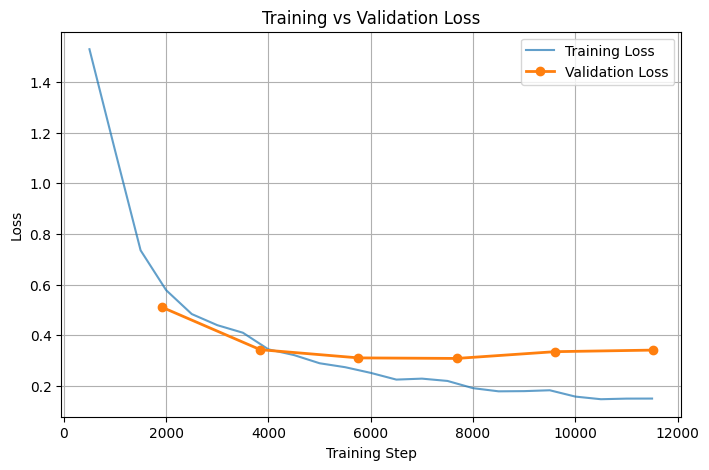

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

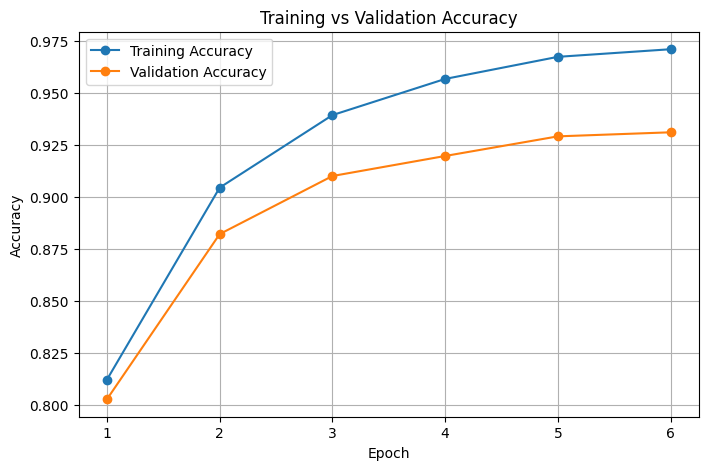

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Check if 'train_accuracy' exists before processing
if "train_accuracy" in logs.columns:
    train_acc = logs.dropna(subset=["train_accuracy"])
else:
    train_acc = pd.DataFrame()
    print("Warning: 'train_accuracy' column not found in logs. Training accuracy plot will be skipped.")

# Check if 'eval_accuracy' exists before processing
# The Trainer should log 'eval_accuracy' if compute_metrics is provided.
if "eval_accuracy" in logs.columns:
    eval_acc = logs.dropna(subset=["eval_accuracy"])
else:
    eval_acc = pd.DataFrame()
    print("Warning: 'eval_accuracy' column not found in logs. Validation accuracy plot will be skipped.")


plt.figure(figsize=(8,5))
plotted_anything = False

if not train_acc.empty:
    plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
    plotted_anything = True

if not eval_acc.empty:
    plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")
    plotted_anything = True

if plotted_anything:
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No accuracy data available to plot after training.")

In [ ]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))

                   precision    recall  f1-score   support

moderate_negative       0.73      0.88      0.79      1026
moderate_positive       0.77      0.84      0.80      1772
         negative       0.96      0.96      0.96      2439
          neutral       0.97      0.90      0.93      5835
         positive       0.95      0.97      0.96      4283

         accuracy                           0.92     15355
        macro avg       0.88      0.91      0.89     15355
     weighted avg       0.93      0.92      0.92     15355



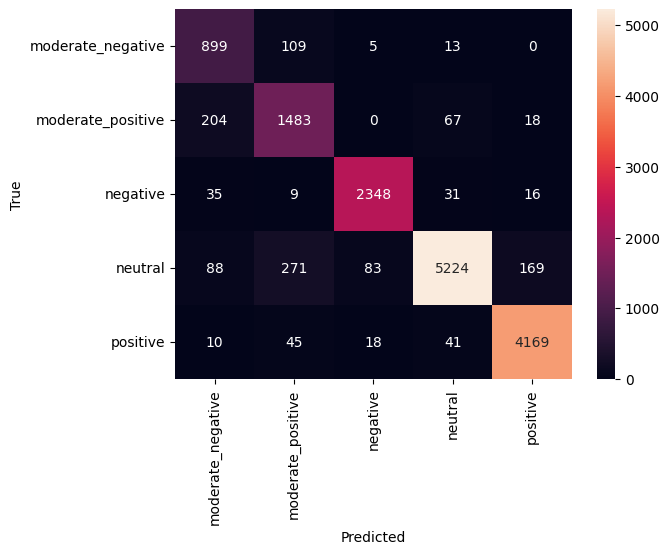

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
trainer.save_model("/content/drive/MyDrive/finbert_5class_model_v4")
tokenizer.save_pretrained("/content/drive/MyDrive/finbert_5class_model_v4")

('/content/drive/MyDrive/finbert_5class_model_v4/tokenizer_config.json',
 '/content/drive/MyDrive/finbert_5class_model_v4/special_tokens_map.json',
 '/content/drive/MyDrive/finbert_5class_model_v4/vocab.txt',
 '/content/drive/MyDrive/finbert_5class_model_v4/added_tokens.json',
 '/content/drive/MyDrive/finbert_5class_model_v4/tokenizer.json')